In [1]:
import seaborn as sns
import metapack as mp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display 
import h5py 

# Setup importing form this package
doc = mp.jupyter.open_source_package()
doc.set_sys_path()
import pylib # Import the code for the package

%matplotlib inline
sns.set_context('notebook')
mp.jupyter.init()

In [2]:
#pkg = mp.jupyter.open_package()
pkg = mp.jupyter.open_source_package()

ntl_p = pkg.reference('ntl').package
df = sez = pkg.reference('sez').resource.geoframe()
sez.head()

,id,unique_id,check,latitude,longitude,country_code,country_type_combo,region,country,zone_type,...,populous_citydist,city_1m,city_1mdist,city_500k,city_500kdist,500kcity_range,city_300k,city_300kdist,note,geometry
0,0,URY12,URY,-33.887443,-58.416899,URY,URYFree Zone,LAC,Uruguay,Free Zone,...,265,Montevideo,265,Montevideo,265,50 to 299 km,Montevideo,265,NaN,POINT (-58.41690 -33.88744)
1,1,URY2,URY,-34.470636,-57.831424,URY,URYFree Zone,LAC,Uruguay,Free Zone,...,182,Montevideo,182,Montevideo,182,50 to 299 km,Montevideo,182,NaN,POINT (-57.83142 -34.47064)
2,2,COL2,COL,10.960451,-74.762902,COL,COLFree Industrial Zone,LAC,Colombia,Free Industrial Zone,...,1013,Barranquilla,6,Barranquilla,6,Less than 50 km,Barranquilla,6,NaN,POINT (-74.76290 10.96045)
3,3,GUY3,GUY,6.791794,-58.167016,GUY,GUYIndustrial Estate,LAC,Guyana,Industrial Estate,...,4,No city in country with population greater tha...,0,No city in country with population greater tha...,0,Less than 50 km,No city in country with population greater tha...,0,The Government has noted that existing industr...,POINT (-58.16702 6.79179)
4,4,IND186,IND,23.034146,70.127156,IND,INDSpecial Economic Zone,SA,India,Special Economic Zone,...,830,Rajkot,191,Morbi,191,50 to 299 km,Morbi,191,NaN,POINT (70.12716 23.03415)


In [3]:
df = sez[sez.unique_id == 'KOR103']
r1 = 5_000

df_buf = df.to_crs(3857).buffer(r1).to_crs(df.crs)

sez_rings, patches, exc, sums_df  = pylib.build_ring_sums(ntl_p, df, r1)


ring ring 5000:   0%|          | 0/27 [00:00<?, ?it/s]

In [4]:
import rasterio
import rasterio.plot

ref = ntl_p.reference(f'ntl2006').resolved_url.get_resource().get_target()

with rasterio.open(str(ref.fspath)) as src:
    img, ring_transform = rasterio.mask.mask(src, sez_rings.ring, crop=True)
    ring_img = img[0,:,:].astype(float)
    ring_img[ring_img==0]=np.nan
    
    img, buf_transform = rasterio.mask.mask(src, df_buf, crop=True)
    buf_img = img[0,:,:].astype(float)
    buf_img[buf_img==0]=np.nan
    
    
    


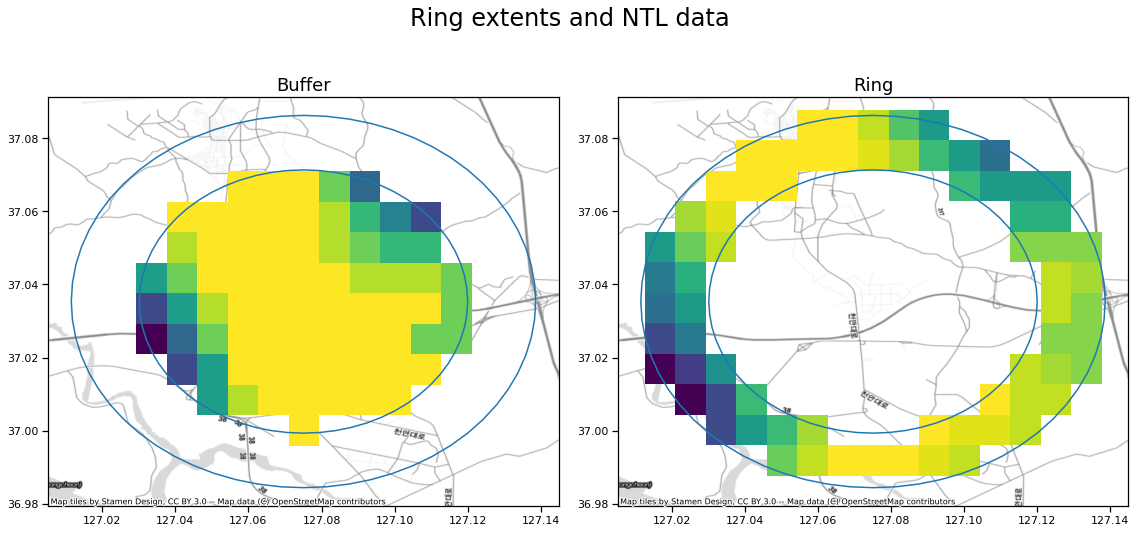

In [18]:
import contextily as ctx 
fig, axes = plt.subplots(1, 2,figsize=(16, 8))

ax=sez_rings.ring.boundary.plot(ax=axes[0])
ctx.add_basemap(ax, crs=4326, source=ctx.providers.Stamen.TonerLite)
rasterio.plot.show(buf_img, ax=ax, transform=buf_transform)
ax.set_title('Buffer', fontsize=18)

ax = sez_rings.ring.boundary.plot(ax=axes[1])
ctx.add_basemap(ax, crs=4326, source=ctx.providers.Stamen.TonerLite)
rasterio.plot.show(ring_img, ax=ax, transform=ring_transform)
ax.set_title('Ring', fontsize=18)

fig.suptitle('Ring extents and NTL data', fontsize=24)
fig.savefig('../doc/ring_raster.png')

plt.tight_layout()
